# Limpieza y consolidación de datos de ruido ambiental

En este notebook se realiza la **fase de limpieza y preparación del dataset** a partir de los archivos generados en la etapa de scraping.  

Se pretende unificar los datos de todos los sensores disponibles en el rango temporal **común a todas las estaciones**, comprendido entre el **16 de abril de 2025** y el **6 de octubre de 2025**.  

Esta fase incluye:
- Carga y concatenación de todos los archivos CSV en una sola tabla.  
- Filtrado de registros dentro del rango temporal establecido.  
- Validación de formatos de fecha y valores numéricos.  
- Creación de una tabla consolidada lista para análisis y modelado.  

El resultado será un único dataset limpio y consistente, exportado a la carpeta `data/clean/` para su uso posterior.


In [2]:
# ==============================================================
# 1. Carga y concatenación de datos de todos los sensores
# ==============================================================

import os
import pandas as pd
from datetime import datetime

# Definir rutas
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../"))
DATA_DIR = os.path.join(BASE_DIR, "data")
OUTPUT_DIR = os.path.join(DATA_DIR, "clean")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Rango temporal común
FECHA_INICIO = pd.to_datetime("2025-04-16")
FECHA_FIN = pd.to_datetime("2025-10-06")

# Recolectar todos los archivos CSV
archivos_csv = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".csv")]

if not archivos_csv:
    print("No se encontraron archivos CSV en la carpeta data.")
else:
    print(f"Archivos detectados: {len(archivos_csv)}")

# Lista para acumular datos
dataframes = []

for csv_path in archivos_csv:
    sensor = os.path.splitext(os.path.basename(csv_path))[0]
    try:
        df = pd.read_csv(csv_path)
        df["sensor"] = sensor  # añadir identificador del sensor
        df["timestamp"] = pd.to_datetime(df["fecha"] + " " + df["hora"], errors="coerce")
        df["decibelios"] = pd.to_numeric(df["decibelios"], errors="coerce")

        # Filtrar por rango de fechas
        df = df[(df["timestamp"] >= FECHA_INICIO) & (df["timestamp"] <= FECHA_FIN)]

        dataframes.append(df)
    except Exception as e:
        print(f"Error procesando {csv_path}: {e}")

# Concatenar todos los datos
if dataframes:
    df_all = pd.concat(dataframes, ignore_index=True)
    print(f"Total de registros combinados: {len(df_all)}")
else:
    df_all = pd.DataFrame()
    print("No se generó ningún DataFrame válido.")


Archivos detectados: 8
Total de registros combinados: 188676


In [3]:
# ==============================================================
# 2. Limpieza final y exportación del dataset consolidado
# ==============================================================

if df_all.empty:
    print("No hay datos para limpiar o exportar.")
else:
    # ----------------------------------------------------------
    # Seleccionar y reordenar columnas relevantes
    # ----------------------------------------------------------
    columnas_finales = ["sensor", "fecha", "hora", "timestamp", "decibelios"]
    df_final = df_all[columnas_finales].copy()

    # Asegurar consistencia de tipos
    df_final["fecha"] = pd.to_datetime(df_final["fecha"], errors="coerce")
    df_final["hora"] = df_final["hora"].astype(str)
    df_final["decibelios"] = pd.to_numeric(df_final["decibelios"], errors="coerce")

    # Eliminar filas sin timestamp o sin valor válido de decibelios
    df_final = df_final.dropna(subset=["timestamp", "decibelios"])

    # Ordenar por sensor y fecha
    df_final = df_final.sort_values(by=["sensor", "timestamp"]).reset_index(drop=True)

    # ----------------------------------------------------------
    # Exportar dataset limpio
    # ----------------------------------------------------------
    output_path = os.path.join(OUTPUT_DIR, "ruido_cuenca_clean.csv")
    df_final.to_csv(output_path, index=False, encoding="utf-8")

    print("Archivo consolidado exportado correctamente.")
    print(f"Ruta de salida: {output_path}")
    print(f"Total de registros finales: {len(df_final)}")
    print(f"Sensores incluidos: {df_final['sensor'].nunique()}")


Archivo consolidado exportado correctamente.
Ruta de salida: c:\Users\arian\Documents\ruido-cuenca\data\clean\ruido_cuenca_clean.csv
Total de registros finales: 188676
Sensores incluidos: 8


Registros cargados: 188676

Resumen general de niveles de ruido (en dB):


,count,mean,std,min,25%,50%,75%,max
decibelios,135400.0,65.5,8.52,37.25,61.42,68.16,71.31,87.67


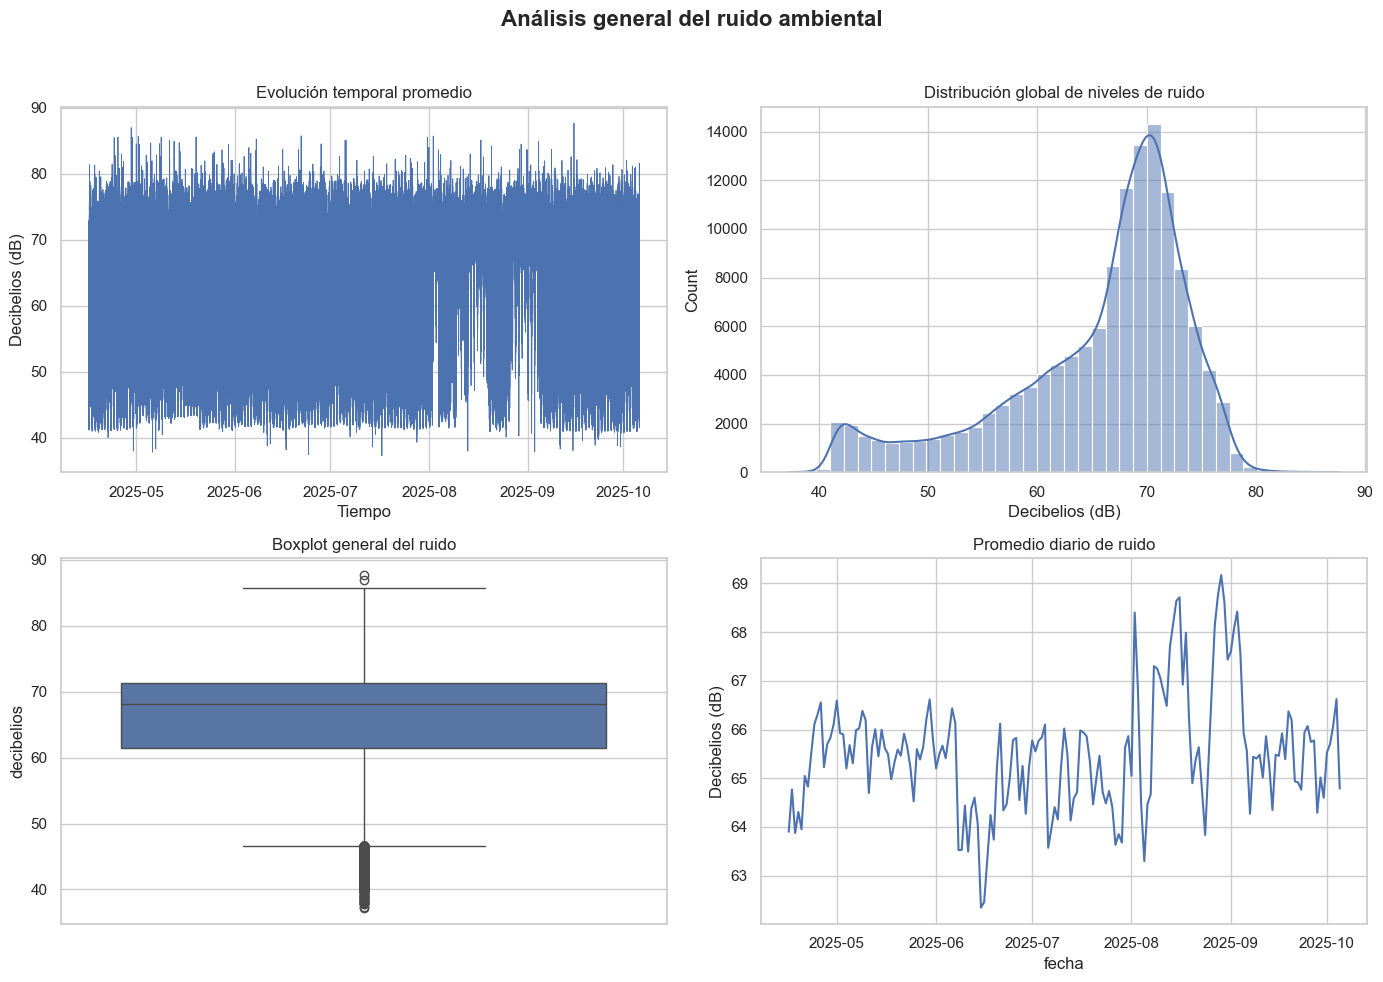

In [4]:
# ==============================================================
# 3. Resumen general del dataset consolidado
# ==============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Verificar que el archivo limpio existe
clean_path = os.path.join(OUTPUT_DIR, "ruido_cuenca_clean.csv")
if not os.path.exists(clean_path):
    print("No se encontró el archivo limpio. Ejecute el bloque anterior primero.")
else:
    df = pd.read_csv(clean_path, parse_dates=["timestamp", "fecha"])
    print(f"Registros cargados: {len(df)}")

    # ----------------------------------------------------------
    # Agrupar por timestamp y promediar si hay duplicados
    # ----------------------------------------------------------
    df_mean = df.groupby("timestamp", as_index=False)["decibelios"].mean()

    # ----------------------------------------------------------
    # Resumen estadístico
    # ----------------------------------------------------------
    resumen = df_mean["decibelios"].describe().round(2)
    print("\nResumen general de niveles de ruido (en dB):")
    display(resumen.to_frame().T)

    # ----------------------------------------------------------
    # Gráficos agregados
    # ----------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Análisis general del ruido ambiental", fontsize=16, weight="bold")

    # 1. Evolución temporal (todo el periodo)
    sns.lineplot(data=df_mean, x="timestamp", y="decibelios", ax=axes[0, 0], linewidth=0.6)
    axes[0, 0].set_title("Evolución temporal promedio")
    axes[0, 0].set_xlabel("Tiempo")
    axes[0, 0].set_ylabel("Decibelios (dB)")

    # 2. Distribución global
    sns.histplot(df_mean["decibelios"], bins=40, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title("Distribución global de niveles de ruido")
    axes[0, 1].set_xlabel("Decibelios (dB)")

    # 3. Boxplot general
    sns.boxplot(y=df_mean["decibelios"], ax=axes[1, 0])
    axes[1, 0].set_title("Boxplot general del ruido")

    # 4. Promedio diario
    df_mean["fecha"] = df_mean["timestamp"].dt.date
    daily_avg = df_mean.groupby("fecha")["decibelios"].mean()
    daily_avg.plot(ax=axes[1, 1])
    axes[1, 1].set_title("Promedio diario de ruido")
    axes[1, 1].set_ylabel("Decibelios (dB)")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Comparación entre sensores y análisis de diferencias

En esta sección se realiza un análisis comparativo de los niveles de ruido registrados por cada sensor.  
El objetivo es identificar posibles **desviaciones sistemáticas** entre sensores, lo que permitirá decidir si es necesario aplicar un proceso de **normalización o calibración relativa**.

El análisis incluye:
- Cálculo de estadísticas descriptivas por sensor (media, desviación estándar, mínimo, máximo, número de registros).  
- Estimación de **distancias estadísticas** entre sensores en base a sus promedios.  
- Visualización comparativa mediante gráficos de distribución y boxplots.  

Este paso es clave para evaluar la homogeneidad de los datos antes de construir un dataset unificado para modelado.


Registros cargados: 188676

Resumen estadístico por sensor:


,sensor,count,mean,std,min,max,rango
0,ruido_SCP01,23140,45.96,3.86,39.72,65.75,26.03
1,ruido_SCP06,23676,65.64,5.43,46.57,86.43,39.86
2,ruido_SCP07,23653,64.24,6.28,37.25,89.44,52.19
3,ruido_SCP08,24351,68.34,3.58,54.14,85.02,30.88
4,ruido_SCP09,23515,73.21,4.18,57.06,86.40,29.34
5,ruido_SCP13,23677,71.24,4.49,55.41,87.67,32.26
6,ruido_SCP16,23036,67.76,5.24,47.69,84.70,37.01
7,ruido_SCP17,23628,67.32,5.48,46.88,86.73,39.85



Matriz de diferencias absolutas promedio (en dB):


,ruido_SCP01,ruido_SCP06,ruido_SCP07,ruido_SCP08,ruido_SCP09,ruido_SCP13,ruido_SCP16,ruido_SCP17
ruido_SCP01,0.00,19.68,18.28,22.38,27.25,25.28,21.80,21.36
ruido_SCP06,19.68,0.00,1.40,2.70,7.57,5.60,2.12,1.68
ruido_SCP07,18.28,1.40,0.00,4.10,8.97,7.00,3.52,3.08
ruido_SCP08,22.38,2.70,4.10,0.00,4.87,2.90,0.58,1.02
ruido_SCP09,27.25,7.57,8.97,4.87,0.00,1.97,5.45,5.89
ruido_SCP13,25.28,5.60,7.00,2.90,1.97,0.00,3.48,3.92
ruido_SCP16,21.80,2.12,3.52,0.58,5.45,3.48,0.00,0.44
ruido_SCP17,21.36,1.68,3.08,1.02,5.89,3.92,0.44,0.00


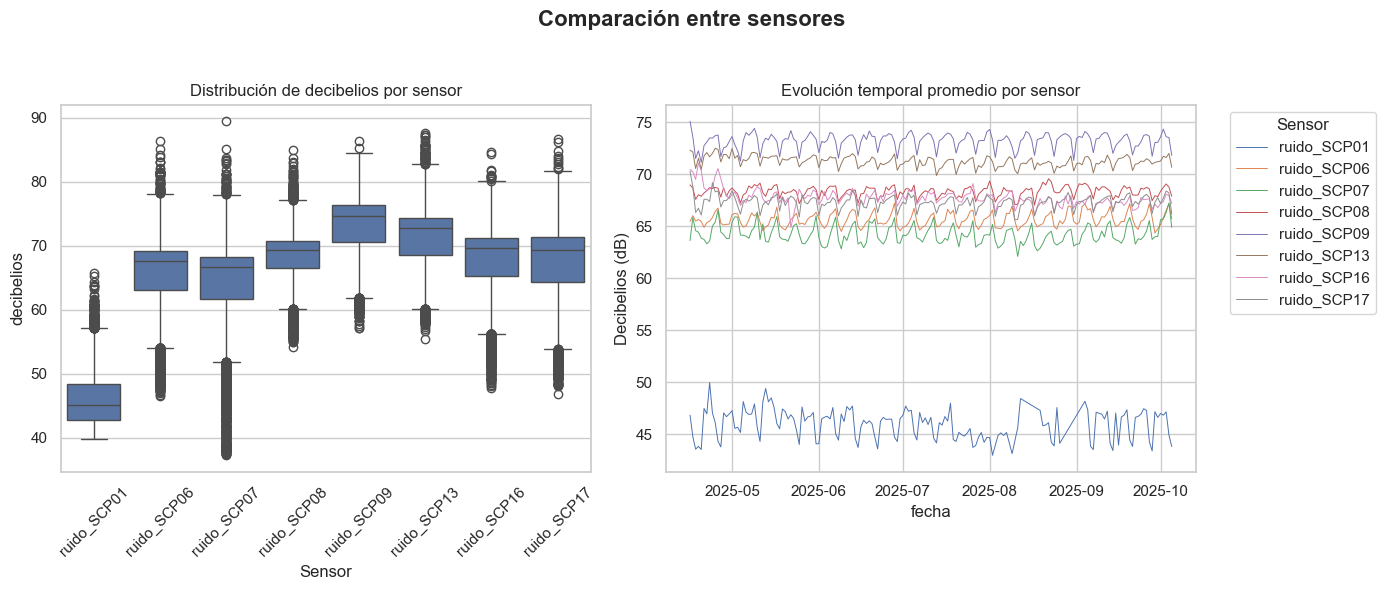

In [5]:
# ==============================================================
# 4. Comparación entre sensores y distancias estadísticas
# ==============================================================

import numpy as np

# Cargar dataset limpio
clean_path = os.path.join(OUTPUT_DIR, "ruido_cuenca_clean.csv")
if not os.path.exists(clean_path):
    print("No se encontró el archivo limpio. Ejecute el bloque anterior primero.")
else:
    df = pd.read_csv(clean_path, parse_dates=["timestamp", "fecha"])
    print(f"Registros cargados: {len(df)}")

    # ----------------------------------------------------------
    # Calcular estadísticas básicas por sensor
    # ----------------------------------------------------------
    resumen_sensores = (
        df.groupby("sensor")["decibelios"]
        .agg(["count", "mean", "std", "min", "max"])
        .round(2)
        .reset_index()
    )
    resumen_sensores["rango"] = resumen_sensores["max"] - resumen_sensores["min"]

    print("\nResumen estadístico por sensor:")
    display(resumen_sensores)

    # ----------------------------------------------------------
    # Calcular distancias entre sensores (basado en diferencia de medias)
    # ----------------------------------------------------------
    sensores = resumen_sensores["sensor"].tolist()
    medias = resumen_sensores["mean"].values

    distancias = pd.DataFrame(
        np.abs(medias[:, None] - medias[None, :]),
        index=sensores,
        columns=sensores
    ).round(2)

    print("\nMatriz de diferencias absolutas promedio (en dB):")
    display(distancias)

    # ----------------------------------------------------------
    # Visualización comparativa
    # ----------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Comparación entre sensores", fontsize=16, weight="bold")

    # Distribución de niveles de ruido por sensor
    sns.boxplot(data=df, x="sensor", y="decibelios", ax=axes[0])
    axes[0].set_title("Distribución de decibelios por sensor")
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].set_xlabel("Sensor")

    # Promedio diario por sensor
    daily_means = df.groupby(["sensor", "fecha"])["decibelios"].mean().reset_index()
    sns.lineplot(data=daily_means, x="fecha", y="decibelios", hue="sensor", ax=axes[1], linewidth=0.7)
    axes[1].set_title("Evolución temporal promedio por sensor")
    axes[1].set_ylabel("Decibelios (dB)")
    axes[1].legend(title="Sensor", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Normalización temporal del dataset

Se pretende usar este bloque para garantizar que todos los sensores tengan el mismo número de registros en el tiempo.  
El objetivo es **alinear las series temporales** bajo una misma rejilla temporal (por ejemplo, cada 10 minutos) y rellenar los valores faltantes.

Los métodos considerados para el completado son:
- **Media o mediana** del propio sensor (método simple, útil cuando hay grandes huecos).  
- **Interpolación temporal lineal**, adecuada para series continuas.  
- **Promedio ponderado por sensores similares y misma hora del día**, que utiliza información espacial y horaria.

Esto produce un dataset estructurado, completamente alineado, que permite comparaciones directas entre sensores o el entrenamiento de modelos multivariados.


In [7]:
# ==============================================================
# 5. Normalización temporal y completado de datos faltantes
# ==============================================================

import numpy as np

clean_path = os.path.join(OUTPUT_DIR, "ruido_cuenca_clean.csv")
if not os.path.exists(clean_path):
    print("No se encontró el archivo limpio. Ejecute los pasos previos primero.")
else:
    df = pd.read_csv(clean_path, parse_dates=["timestamp"])
    print(f"Registros cargados: {len(df)}")

    # ----------------------------------------------------------
    # 1. Crear tabla pivotada (timestamp x sensor)
    # ----------------------------------------------------------
    pivot = df.pivot_table(
        index="timestamp",
        columns="sensor",
        values="decibelios",
        aggfunc="mean"
    ).sort_index()

    print(f"Shape original: {pivot.shape}")

    # ----------------------------------------------------------
    # 2. Crear rejilla temporal uniforme
    # ----------------------------------------------------------
    freq = pivot.index.to_series().diff().dropna().min()  # frecuencia mínima detectada
    full_index = pd.date_range(pivot.index.min(), pivot.index.max(), freq=freq)
    pivot = pivot.reindex(full_index)

    print(f"Rejilla temporal creada: {len(full_index)} timestamps (freq={freq})")

    # ----------------------------------------------------------
    # 3. Método de completado (elige uno)
    # ----------------------------------------------------------
    metodo = "interpolacion"  # opciones: "media", "mediana", "interpolacion", "vecinos"

    if metodo == "media":
        pivot_filled = pivot.fillna(pivot.mean())
        print("Relleno aplicado: media global por sensor")

    elif metodo == "mediana":
        pivot_filled = pivot.fillna(pivot.median())
        print("Relleno aplicado: mediana global por sensor")

    elif metodo == "interpolacion":
        pivot_filled = pivot.interpolate(method="time", limit_direction="both")
        print("Relleno aplicado: interpolación temporal lineal")

    elif metodo == "vecinos":
        # --- Promedio ponderado por sensores similares y misma hora ---
        dist = {
            "SCP01": {"SCP06": 19.68, "SCP07": 18.28, "SCP08": 22.38, "SCP09": 27.25, "SCP13": 25.28, "SCP16": 21.80, "SCP17": 21.36},
            "SCP06": {"SCP01": 19.68, "SCP07": 1.40, "SCP08": 2.70, "SCP09": 7.57, "SCP13": 5.60, "SCP16": 2.12, "SCP17": 1.68},
            "SCP07": {"SCP01": 18.28, "SCP06": 1.40, "SCP08": 4.10, "SCP09": 8.97, "SCP13": 7.00, "SCP16": 3.52, "SCP17": 3.08},
            "SCP08": {"SCP01": 22.38, "SCP06": 2.70, "SCP07": 4.10, "SCP09": 4.87, "SCP13": 2.90, "SCP16": 0.58, "SCP17": 1.02},
            "SCP09": {"SCP01": 27.25, "SCP06": 7.57, "SCP07": 8.97, "SCP08": 4.87, "SCP13": 1.97, "SCP16": 5.45, "SCP17": 5.89},
            "SCP13": {"SCP01": 25.28, "SCP06": 5.60, "SCP07": 7.00, "SCP08": 2.90, "SCP09": 1.97, "SCP16": 3.48, "SCP17": 3.92},
            "SCP16": {"SCP01": 21.80, "SCP06": 2.12, "SCP07": 3.52, "SCP08": 0.58, "SCP09": 5.45, "SCP13": 3.48, "SCP17": 0.44},
            "SCP17": {"SCP01": 21.36, "SCP06": 1.68, "SCP07": 3.08, "SCP08": 1.02, "SCP09": 5.89, "SCP13": 3.92, "SCP16": 0.44}
        }

        pivot_filled = pivot.copy()
        sensores = pivot.columns

        for s in sensores:
            missing = pivot[pivot[s].isna()].index
            for t in missing:
                # Filtrar sensores con datos en ese timestamp
                disponibles = [x for x in sensores if x != s and not np.isnan(pivot.loc[t, x])]
                if not disponibles:
                    continue

                # Ponderación inversa a la distancia
                pesos = np.array([1 / (dist[s][x] + 1e-6) for x in disponibles if x in dist[s]])
                valores = np.array([pivot.loc[t, x] for x in disponibles if x in dist[s]])
                if len(pesos) > 0 and len(valores) > 0:
                    pivot_filled.loc[t, s] = np.average(valores, weights=pesos)

        print("Relleno aplicado: ponderación por sensores vecinos similares")

    else:
        raise ValueError("Método de completado no reconocido.")

    # ----------------------------------------------------------
    # 4. Exportar resultado final
    # ----------------------------------------------------------
    output_path = os.path.join(OUTPUT_DIR, "ruido_cuenca_sync.csv")
    pivot_filled.to_csv(output_path, index=True, encoding="utf-8")

    completitud = 100 * (1 - pivot_filled.isna().mean().mean())
    print(f"Dataset sincronizado exportado correctamente.")
    print(f"Ruta: {output_path}")
    print(f"Completitud total: {completitud:.2f}%")
    print(f"Shape final: {pivot_filled.shape}")


Registros cargados: 188676
Shape original: (135400, 8)
Rejilla temporal creada: 249119 timestamps (freq=0 days 00:01:00)
Relleno aplicado: interpolación temporal lineal
Dataset sincronizado exportado correctamente.
Ruta: c:\Users\arian\Documents\ruido-cuenca\data\clean\ruido_cuenca_sync.csv
Completitud total: 100.00%
Shape final: (249119, 8)


## Visualización comparativa de sensores

En esta sección se busca comparar la evolución temporal y la distribución general de los niveles de ruido entre sensores.

- Se representa la **serie temporal de cada sensor** en un mismo eje temporal, permitiendo observar similitudes, picos y variaciones entre ubicaciones.  
- Se incluye un **violinplot comparativo**, que combina la forma de la distribución y su densidad, ofreciendo una visión más completa que el boxplot tradicional.


Dataset cargado: 249119 registros × 8 sensores


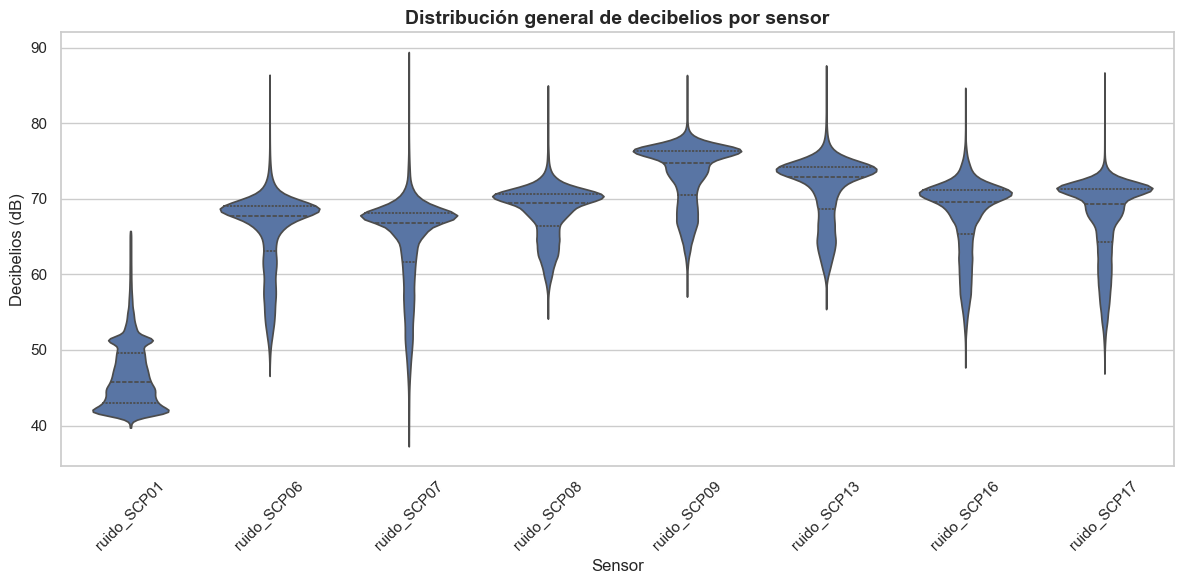

In [12]:
# ==============================================================
# 6. Visualización comparativa de sensores (líneas + violines)
# ==============================================================

sync_path = os.path.join(OUTPUT_DIR, "ruido_cuenca_sync.csv")
if not os.path.exists(sync_path):
    print("No se encontró el archivo sincronizado. Ejecute los pasos previos.")
else:
    # Cargar CSV con índice temporal
    df_sync = pd.read_csv(sync_path, index_col=0, parse_dates=True)

    print(f"Dataset cargado: {df_sync.shape[0]} registros × {df_sync.shape[1]} sensores")

    # ----------------------------------------------------------
    # Violinplot comparativo por sensor
    # ----------------------------------------------------------
    # Si el índice no tiene nombre, se renombra temporalmente
    df_reset = df_sync.reset_index()
    if df_reset.columns[0] != "timestamp":
        df_reset.rename(columns={df_reset.columns[0]: "timestamp"}, inplace=True)

    # Convertir a formato largo
    df_long = df_reset.melt(id_vars="timestamp", var_name="sensor", value_name="decibelios")

    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df_long, x="sensor", y="decibelios", inner="quartile", cut=0)
    plt.title("Distribución general de decibelios por sensor", fontsize=14, weight="bold")
    plt.xlabel("Sensor")
    plt.ylabel("Decibelios (dB)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



### Interpretación del gráfico de distribución de decibelios por sensor

Al analizar las distribuciones mostradas en el gráfico de violín:

- **SCP01 (Oficinas IERSE)** presenta los **niveles de ruido más bajos** entre todos los sensores, con una concentración marcada alrededor de los **45 dB** y poca dispersión. Esto confirma que se trata de un entorno más controlado y silencioso, coherente con su ubicación institucional.

- **SCP06 (Remigio Crespo)** y **SCP07 (Estadio Serrano Aguilar)** muestran la **mayor variabilidad** entre sus valores mínimos y máximos, reflejando un entorno acústico más dinámico y cambiante. Esta amplitud puede estar asociada a la intensidad del tráfico, eventos deportivos o actividades comerciales en sus zonas.

- El **resto de los sensores (SCP08, SCP09, SCP13, SCP16 y SCP17)** exhiben **distribuciones más homogéneas**, con valores centrados alrededor de los **70 dB**, lo que sugiere un comportamiento estable y sostenido del nivel de ruido a lo largo del tiempo, sin grandes fluctuaciones extremas.

En conjunto, las diferencias entre sensores reflejan la influencia directa del tipo de uso de suelo y la actividad humana circundante sobre la variabilidad del ruido ambiental.


In [ ]:
import os
import json
import pandas as pd
import folium
from folium.plugins import TimestampedGeoJson
from branca.colormap import linear
from branca.colormap import StepColormap
from tqdm import tqdm
from datetime import time
import webbrowser

# ------------------------------------------------------
# 1. Cargar datos sincronizados y marcadores
# ------------------------------------------------------
sync_path = os.path.join(BASE_DIR, "data", "clean", "ruido_cuenca_sync.csv")
markers_path = os.path.join(BASE_DIR, "src", "scraping", "markers.json")

df = pd.read_csv(sync_path, index_col=0, parse_dates=True)
df.reset_index(inplace=True)
df.rename(columns={"index": "timestamp"}, inplace=True)

with open(markers_path, "r", encoding="utf-8") as f:
    markers = json.load(f)

# ------------------------------------------------------
# 2. Reducir frecuencia temporal (promedio cada hora)
# ------------------------------------------------------
df = df.set_index("timestamp").resample("1h").mean().reset_index()

# ------------------------------------------------------
# 3. Preparar mapa base (día por defecto)
# ------------------------------------------------------
m = folium.Map(location=[-2.9, -79.0], zoom_start=13, tiles="CartoDB positron")

# Escala de color invertida (rojo = bajo, azul = alto)

# Invertir manualmente los colores base
colors = linear.RdYlBu_11.colors[::-1]

colormap = StepColormap(
    colors=colors,
    vmin=df.iloc[:, 1:].min().min(),
    vmax=df.iloc[:, 1:].max().max(),
    index=None,
    caption="Nivel de ruido (dB)"
)
colormap.add_to(m)

# ------------------------------------------------------
# 4. Crear estructura GeoJSON temporal con diferencias día/noche
# ------------------------------------------------------
features = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Generando puntos del mapa"):
    timestamp = row["timestamp"]
    hora = timestamp.time()
    is_night = hora < time(6) or hora >= time(18)

    for sensor in [c for c in df.columns if c != "timestamp"]:
        valor = row[sensor]
        marker = next((m for m in markers if f"ruido_{m['id']}" == sensor), None)
        if marker and not pd.isna(valor):
            color = colormap(valor)
            feature = {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": [marker["lon"], marker["lat"]],
                },
                "properties": {
                    "time": timestamp.isoformat(),
                    "style": {"color": color},
                    "icon": "circle",
                    "iconstyle": {
                        "fillColor": color,
                        "fillOpacity": 0.9 if not is_night else 0.6,
                        "stroke": "true",
                        "radius": 9 if not is_night else 7,
                    },
                    "popup": (
                        f"<b>{marker['nombre']}</b><br>"
                        f"{valor:.1f} dB<br>"
                        f"<i>{'🌙 Noche' if is_night else '☀️ Día'}</i>"
                    ),
                },
            }
            features.append(feature)

# ------------------------------------------------------
# 5. Agregar capa temporal
# ------------------------------------------------------
TimestampedGeoJson(
    {"type": "FeatureCollection", "features": features},
    period="PT1H",
    duration="PT30M",
    auto_play=True,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options="YYYY-MM-DD HH:mm",
    time_slider_drag_update=True,
).add_to(m)

# ------------------------------------------------------
# 6. Añadir calendario animado y cambio de fondo día/noche (corregido)
# ------------------------------------------------------
calendar_script = """
<style>
#calendar-widget {
    position: fixed;
    top: 15px;
    left: 50%;
    transform: translateX(-50%);
    background-color: rgba(20, 20, 20, 0.85);
    color: white;
    padding: 15px 25px;
    border-radius: 12px;
    font-family: 'Segoe UI', sans-serif;
    font-weight: bold;
    font-size: 22px;
    text-align: center;
    box-shadow: 0 0 10px rgba(255,255,255,0.2);
    z-index: 9999;
    transition: background-color 0.8s ease, color 0.8s ease;
}
#calendar-widget.daytime {
    background-color: rgba(255, 255, 255, 0.9);
    color: black;
    box-shadow: 0 0 15px rgba(255, 255, 0, 0.3);
}
#calendar-widget.nighttime {
    background-color: rgba(10, 10, 40, 0.85);
    color: #d0d0ff;
    box-shadow: 0 0 15px rgba(100, 100, 255, 0.4);
}
</style>

<div id="calendar-widget">
    <div id="day-name">Lunes</div>
    <div id="date-full">2025-10-01 00:00</div>
</div>

<script>
document.addEventListener('DOMContentLoaded', function() {
    const dayNames = ['Domingo','Lunes','Martes','Miércoles','Jueves','Viernes','Sábado'];
    const mapDiv = document.getElementById('map');
    const widget = document.getElementById('calendar-widget');
    const dayLabel = document.getElementById('day-name');
    const dateLabel = document.getElementById('date-full');
    let darkTiles, lightTiles;

    function ensureTileLayers() {
        if (typeof L === 'undefined' || !window.map) return;
        if (!darkTiles) {
            darkTiles = L.tileLayer('https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png', {
                attribution: '&copy; <a href="https://carto.com/">CARTO</a>'
            });
        }
        if (!lightTiles) {
            lightTiles = L.tileLayer('https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png', {
                attribution: '&copy; <a href="https://carto.com/">CARTO</a>'
            });
        }
    }

    function updateCalendarFromDate(val) {
        if (!val) return;
        const date = new Date(val);
        if (isNaN(date.getTime())) return;

        const dayName = dayNames[date.getDay()];
        const hours = date.getHours();
        const minutes = String(date.getMinutes()).padStart(2, '0');
        const formatted = date.toISOString().slice(0, 10) + ' ' +
                          hours.toString().padStart(2, '0') + ':' + minutes;
        dayLabel.textContent = dayName;
        dateLabel.textContent = formatted;

        // Cambiar fondo día/noche
        ensureTileLayers();
        if (hours >= 6 && hours < 18) {
            widget.classList.add('daytime');
            widget.classList.remove('nighttime');
            if (window.map && darkTiles && lightTiles) {
                if (window.map.hasLayer(darkTiles)) window.map.removeLayer(darkTiles);
                if (!window.map.hasLayer(lightTiles)) window.map.addLayer(lightTiles);
            }
        } else {
            widget.classList.add('nighttime');
            widget.classList.remove('daytime');
            if (window.map && darkTiles && lightTiles) {
                if (window.map.hasLayer(lightTiles)) window.map.removeLayer(lightTiles);
                if (!window.map.hasLayer(darkTiles)) window.map.addLayer(darkTiles);
            }
        }
    }

    const observer = new MutationObserver(() => {
        const mapObj = Object.values(window).find(v => v && v instanceof L.Map);
        if (mapObj) {
            window.map = mapObj;

            // Capturar el control de tiempo (TimeDimension)
            if (mapObj.timeDimension) {
                mapObj.timeDimension.on('timeload', function(e) {
                    if (e.time) updateCalendarFromDate(e.time);
                });
                mapObj.timeDimension.on('timechange', function(e) {
                    if (e.time) updateCalendarFromDate(e.time);
                });
            }
        }

        const slider = document.querySelector('.leaflet-control-timecontrol input[type="range"]');
        if (slider) {
            slider.addEventListener('input', e => updateCalendarFromDate(e.target.value));
            slider.addEventListener('change', e => updateCalendarFromDate(e.target.value));
            observer.disconnect();
        }
    });
    observer.observe(document.body, { childList: true, subtree: true });
});
</script>
"""


m.get_root().html.add_child(folium.Element(calendar_script))

# ------------------------------------------------------
# 7. Guardar y abrir en navegador
# ------------------------------------------------------
output_path = os.path.join(BASE_DIR, "data", "clean", "mapa_ruido_temporal.html")
m.save(output_path)
print(f"✅ Mapa temporal guardado en:\n{output_path}")

webbrowser.open(f"file://{output_path}")


Generando puntos del mapa: 100%|██████████| 4152/4152 [00:00<00:00, 7411.92it/s]


✅ Mapa temporal guardado en:
c:\Users\arian\Documents\ruido-cuenca\data\clean\mapa_ruido_temporal.html


True